<a href="https://colab.research.google.com/github/davepy99/RadarProcessing/blob/main/DOA_Estimation_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import torch
import numpy as np

# Load data from .mat file
with h5py.File('DOA_Training_Data_2deg.mat', 'r') as f:
    X_raw = np.array(f['covSet'])          # shape: (10000, 8, 8)
    Y = np.array(f['labelSet'])       # shape: (5000, 181)
    angleGrid = np.array(f['angleGrid']).flatten()


# Split into real and imag
N = Y.shape[0]
X_real = X_raw[:N]
X_imag = X_raw[N:2*N]

# Combine into 2-channel tensor: [N, 2, 8, 8]
X = np.stack([X_real, X_imag], axis=1)

# Normalize
mean = X.mean()
std = X.std()
X = (X - mean) / std

# Convert to torch
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class DOADataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Split into training and test set
train_size = int(0.8 * len(X))
train_ds = DOADataset(X[:train_size], Y[:train_size])
test_ds = DOADataset(X[train_size:], Y[train_size:])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


In [ ]:
import torch.nn as nn

class DOACNN(nn.Module):
    def __init__(self, output_bins):
        super(DOACNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc_block = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, output_bins)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.fc_block(x))  # Multi-label prediction

model = DOACNN(output_bins=Y.shape[1])



In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/20, Loss: 0.1046
Epoch 2/20, Loss: 0.0696
Epoch 3/20, Loss: 0.0619
Epoch 4/20, Loss: 0.0578
Epoch 5/20, Loss: 0.0550
Epoch 6/20, Loss: 0.0531
Epoch 7/20, Loss: 0.0517
Epoch 8/20, Loss: 0.0507
Epoch 9/20, Loss: 0.0497
Epoch 10/20, Loss: 0.0491
Epoch 11/20, Loss: 0.0483
Epoch 12/20, Loss: 0.0478
Epoch 13/20, Loss: 0.0473
Epoch 14/20, Loss: 0.0468
Epoch 15/20, Loss: 0.0464
Epoch 16/20, Loss: 0.0460
Epoch 17/20, Loss: 0.0454
Epoch 18/20, Loss: 0.0452
Epoch 19/20, Loss: 0.0448
Epoch 20/20, Loss: 0.0446


🔮 Estimated DOAs: [16.0, 36.0, 66.0, 68.0]
✅ Ground Truth DOAs: [16.0, 38.0, 68.0]


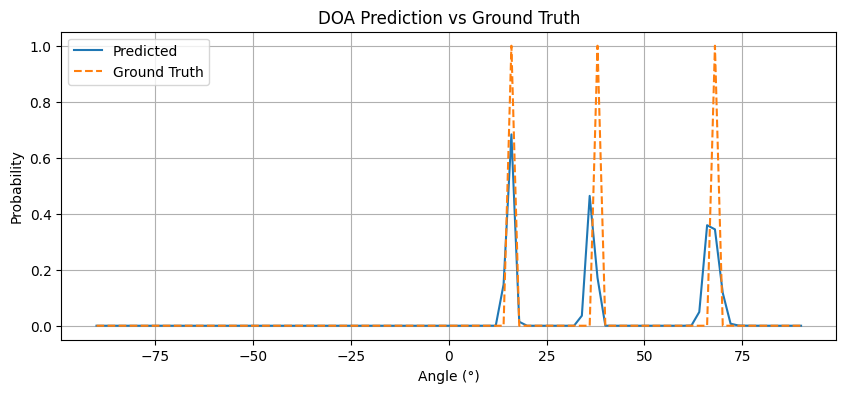

In [ ]:
import matplotlib.pyplot as plt

# Test on a single example
model.eval()
sample_idx = 1000
test_output = model(X[sample_idx:sample_idx+1])
predicted_bins = (test_output > 0.3).nonzero(as_tuple=True)[1]
predicted_angles = angleGrid[predicted_bins]

# Ground truth
true_bins = (Y[sample_idx] > 0.5).nonzero(as_tuple=True)[0]
true_angles = angleGrid[true_bins]

print("🔮 Estimated DOAs:", predicted_angles.tolist())
print("✅ Ground Truth DOAs:", true_angles.tolist())

# Optional: visualize
plt.figure(figsize=(10, 4))
plt.plot(angleGrid, test_output[0].detach().numpy(), label="Predicted")
plt.plot(angleGrid, Y[sample_idx].numpy(), '--', label="Ground Truth")
plt.title("DOA Prediction vs Ground Truth")
plt.xlabel("Angle (°)")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import h5py
import numpy as np
import torch

# Load .mat test data
# with h5py.File('DOA_Test_Data_2deg.mat', 'r') as f:
with h5py.File('DOA_Test_Data_2deg_narrow.mat', 'r') as f:
    test_X_raw = np.array(f['covSet'])          # shape: [4000, 8, 8]
    test_Y_raw = np.array(f['labelSet'])        # shape: [2000, 91]
    test_angleGrid = np.array(f['angleGrid']).flatten()

# Number of test examples
test_N = test_Y_raw.shape[0]  # = 2000

# Split real and imag from stacked samples
test_X_real = test_X_raw[:test_N]              # shape: [2000, 8, 8]
test_X_imag = test_X_raw[test_N:2*test_N]      # shape: [2000, 8, 8]

# Stack into [N, 2, 8, 8]
test_X = np.stack([test_X_real, test_X_imag], axis=1)  # [2000, 2, 8, 8]

# Normalize using training mean and std
test_X = (test_X - mean) / std  # mean and std from training data

# Convert to torch tensors
test_X = torch.tensor(test_X, dtype=torch.float32)
test_Y = torch.tensor(test_Y_raw, dtype=torch.float32)  # already shape [2000, 91]


In [ ]:
for test_number in range (10):
  test_number = test_number+100
  test_output = model(test_X[test_number:(test_number+1)])
  (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
  predicted_indices = (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
  predicted_angles = test_angleGrid[predicted_indices]
  print("Estimated DOAs:", predicted_angles.tolist())

  (test_Y[test_number] > 0.5).nonzero(as_tuple=True)[0]
  predicted_indices = (test_Y[test_number] > 0.15).nonzero(as_tuple=True)[0]
  predicted_angles = test_angleGrid[predicted_indices]
  print("Real DOAs:", predicted_angles.tolist())

Estimated DOAs: [-62.0, -60.0]
Real DOAs: -60.0
Estimated DOAs: [-42.0, -40.0]
Real DOAs: -42.0
Estimated DOAs: [-6.0, -4.0, 54.0, 56.0]
Real DOAs: [-4.0, 54.0]
Estimated DOAs: [50.0, 52.0, 54.0, 56.0, 58.0]
Real DOAs: [52.0, 58.0]
Estimated DOAs: [-26.0, -24.0, -22.0, -20.0]
Real DOAs: [-26.0, -20.0]
Estimated DOAs: [-38.0, -36.0, -2.0, 0.0, 34.0, 36.0]
Real DOAs: [-38.0, -2.0, 36.0]
Estimated DOAs: [56.0, 58.0, 60.0, 62.0, 64.0, 66.0, 68.0]
Real DOAs: [58.0, 64.0]
Estimated DOAs: [-36.0, 40.0, 42.0, 44.0, 46.0, 62.0, 66.0, 68.0]
Real DOAs: [-36.0, 44.0, 62.0]
Estimated DOAs: [-70.0, -68.0, -66.0, -64.0, -62.0, -44.0, -42.0]
Real DOAs: [-70.0, -64.0, -42.0]
Estimated DOAs: [-14.0, -12.0, 24.0, 26.0, 28.0, 30.0, 32.0]
Real DOAs: [-12.0, 26.0, 34.0]


In [ ]:
(test_Y[test_number] > 0.5).nonzero(as_tuple=True)[0]
predicted_indices = (test_Y[test_number] > 0.15).nonzero(as_tuple=True)[0]
predicted_angles = test_angleGrid[predicted_indices]
print("Estimated DOAs:", predicted_angles.tolist())

Estimated DOAs: [-12.0, 26.0, 34.0]


In [ ]:
def group_estimated_DOAs(estimated_angles, tolerance=3, padding=5, min_angle=-90.0, max_angle=90.0):
    """Group estimated DOAs into scan ranges, clipped to [-90, 90]."""

    # Convert scalar to list
    if isinstance(estimated_angles, (float, int, np.float32, np.float64)):
        estimated_angles = [float(estimated_angles)]
    else:
        estimated_angles = list(estimated_angles)

    if len(estimated_angles) == 0:
        return []

    estimated_angles.sort()

    if len(estimated_angles) == 1:
        angle = float(estimated_angles[0])
        low = max(angle - padding, min_angle)
        high = min(angle + padding, max_angle)
        return [(low, high)]

    groups = [[estimated_angles[0]]]

    for angle in estimated_angles[1:]:
        if angle - groups[-1][-1] <= tolerance:
            groups[-1].append(angle)
        else:
            groups.append([angle])

    # Build and clip ranges
    scan_ranges = []
    for group in groups:
        low = max(float(min(group)) - padding, min_angle)
        high = min(float(max(group)) + padding, max_angle)
        scan_ranges.append((low, high))

    return scan_ranges


In [ ]:
for test_number in range (10):
  test_number = test_number+99
  test_output = model(test_X[test_number:(test_number+1)])
  (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
  predicted_indices = (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
  predicted_angles = test_angleGrid[predicted_indices]
  ranges = group_estimated_DOAs(predicted_angles)
  print("Estimated Ranges:", ranges)

  (test_Y[test_number] > 0.5).nonzero(as_tuple=True)[0]
  predicted_indices = (test_Y[test_number] > 0.15).nonzero(as_tuple=True)[0]
  predicted_angles = test_angleGrid[predicted_indices]
  print("Real DOAs:", predicted_angles.tolist())

Estimated Ranges: [(-53.0, -39.0), (-11.0, 1.0)]
Real DOAs: [-46.0, -6.0]
Estimated Ranges: [(-67.0, -55.0)]
Real DOAs: -60.0
Estimated Ranges: [(-47.0, -35.0)]
Real DOAs: -42.0
Estimated Ranges: [(-11.0, 1.0), (49.0, 61.0)]
Real DOAs: [-4.0, 54.0]
Estimated Ranges: [(45.0, 63.0)]
Real DOAs: [52.0, 58.0]
Estimated Ranges: [(-31.0, -15.0)]
Real DOAs: [-26.0, -20.0]
Estimated Ranges: [(-43.0, -31.0), (-7.0, 5.0), (29.0, 41.0)]
Real DOAs: [-38.0, -2.0, 36.0]
Estimated Ranges: [(51.0, 73.0)]
Real DOAs: [58.0, 64.0]
Estimated Ranges: [(-41.0, -31.0), (35.0, 51.0), (57.0, 67.0), (61.0, 73.0)]
Real DOAs: [-36.0, 44.0, 62.0]
Estimated Ranges: [(-75.0, -57.0), (-49.0, -37.0)]
Real DOAs: [-70.0, -64.0, -42.0]


In [ ]:
def is_DOA_covered(true_angles, predicted_ranges):
    """Check if all true DOAs are covered by predicted ranges (robust to scalar)."""
    # Ensure true_angles is iterable
    if isinstance(true_angles, (float, int, np.float32, np.float64)):
        true_angles = [float(true_angles)]
    else:
        true_angles = list(true_angles)

    for angle in true_angles:
        if not any(low <= angle <= high for (low, high) in predicted_ranges):
            return False  # one DOA is not covered
    return True


In [ ]:
model.eval()
covered_count = 0
total_samples = 2000

with torch.no_grad():
    for i in range(total_samples):
        test_output = model(test_X[i:(i+1)])
        (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_indices = (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_angles = test_angleGrid[predicted_indices]
        scan_ranges = group_estimated_DOAs(predicted_angles)

        # print(scan_ranges)
        true_bins = (test_Y[i] > 0.5).nonzero(as_tuple=True)[0]
        true_angles = test_angleGrid[true_bins]
        # print(true_angles)
        if is_DOA_covered(true_angles, scan_ranges):
            covered_count += 1

coverage_accuracy = covered_count / total_samples
print(f"✅ DOA Coverage Accuracy: {coverage_accuracy:.2%}")


✅ DOA Coverage Accuracy: 91.75%


In [ ]:
model(test_X[i:(i+1)])

tensor([[2.7992e-05, 2.5194e-05, 9.5969e-06, 1.3402e-05, 4.0081e-06, 3.8714e-06,
         5.2002e-06, 6.6930e-06, 6.1239e-07, 5.4525e-07, 4.8910e-06, 4.3549e-06,
         1.1347e-05, 1.0929e-05, 2.7873e-05, 1.4384e-05, 1.7075e-04, 8.9838e-03,
         1.6972e-01, 3.2306e-01, 5.6320e-01, 1.1064e-01, 1.7215e-03, 3.0305e-05,
         6.6514e-08, 3.6708e-08, 1.4051e-08, 1.7311e-07, 3.9081e-07, 8.4191e-07,
         2.4856e-05, 2.2884e-03, 1.4777e-01, 5.5360e-01, 1.4888e-01, 1.4931e-03,
         7.4075e-06, 4.4176e-08, 4.0385e-10, 3.9766e-10, 1.1338e-09, 5.6713e-08,
         1.9047e-05, 1.3483e-02, 2.5516e-01, 4.1194e-01, 2.6215e-01, 3.3356e-03,
         4.5634e-06, 3.0321e-08, 9.4020e-08, 3.1773e-09, 5.8969e-09, 4.0909e-09,
         2.3605e-07, 9.0316e-07, 3.4173e-08, 2.5827e-09, 8.1544e-10, 3.8529e-10,
         6.7494e-12, 2.3269e-11, 9.0603e-10, 8.6874e-09, 9.6022e-09, 8.4515e-08,
         1.3652e-06, 7.7228e-06, 1.9492e-06, 2.7290e-08, 2.2662e-07, 4.5805e-08,
         5.3454e-08, 2.3592e

In [ ]:
total_scan_width = 0.0

model.eval()
covered_count = 0
total_samples = len(test_X)

with torch.no_grad():
    for i in range(total_samples):
        test_output = model(test_X[i:(i+1)])
        (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_indices = (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_angles = test_angleGrid[predicted_indices]
        scan_ranges = group_estimated_DOAs(predicted_angles)

        # === New: Measure scan width ===
        for low, high in scan_ranges:
            total_scan_width += (high - low)

        # === Coverage check (optional) ===
        true_bins = (test_Y[i] > 0.5).nonzero(as_tuple=True)[0]
        true_angles = test_angleGrid[true_bins]

        if is_DOA_covered(true_angles, scan_ranges):
            covered_count += 1

# Metrics
coverage_accuracy = covered_count / total_samples
avg_scan_fraction = total_scan_width / (total_samples * 180.0)

print(f"DOA Coverage Accuracy: {coverage_accuracy:.2%}")
print(f"Avg. Scan Coverage: {avg_scan_fraction:.2%} of 180°")
print(f"Avg. Time Saved: {(1 - avg_scan_fraction):.2%}")


DOA Coverage Accuracy: 91.75%
Avg. Scan Coverage: 12.00% of 180°
Avg. Time Saved: 88.00%


In [ ]:
## MUSIC Part

In [ ]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt

def apply_music(cov_matrix, scan_angles, num_sources, M=8):
    """Standard MUSIC algorithm on a reduced scan range."""
    R = cov_matrix
    _, E = eig(R)
    E = np.fliplr(E)  # sort eigenvectors by descending eigenvalues (rough)
    En = E[:, num_sources:]  # noise subspace

    d = 0.5  # spacing in wavelengths
    spectrum = []

    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(1j * 2 * np.pi * d * np.arange(M) * np.sin(theta))[:, np.newaxis]
        psd = 1 / np.abs((a.conj().T @ En @ En.conj().T @ a))[0, 0]
        spectrum.append(psd.real)

    spectrum = np.array(spectrum)
    spectrum_dB = 10 * np.log10(spectrum / np.max(spectrum))
    return spectrum_dB


In [ ]:
model.eval()
predicted_DOAs = []

with torch.no_grad():
    for i in range(1):
        test_output = model(test_X[i:(i+1)])
        (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_indices = (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_angles = test_angleGrid[predicted_indices]
        scan_ranges = group_estimated_DOAs(predicted_angles)


        # Combine scan ranges into one list of angles to evaluate
        scan_angles = []
        for low, high in scan_ranges:
            scan_angles += list(np.arange(np.ceil(low), np.floor(high)+1, 1))  # 1° steps

        scan_angles = sorted(set(scan_angles))  # remove duplicates
        print(scan_angles)
        # Rebuild full complex covariance matrix from real + imag
        R_real = test_X[i, 0].numpy()
        R_imag = test_X[i, 1].numpy()
        R = R_real + 1j * R_imag
        print(R)
        # Estimate number of sources (or assume known)
        num_sources = int(test_Y[i].sum().item())  # or fixed, e.g. 2

        # Apply MUSIC
        spectrum_dB = apply_music(R, scan_angles, num_sources=num_sources)
        peak_indices = np.argpartition(spectrum_dB, -num_sources)[-num_sources:]
        estimated = [scan_angles[k] for k in sorted(peak_indices)]
        predicted_DOAs.append(estimated)


[np.float64(65.0), np.float64(66.0), np.float64(67.0), np.float64(68.0), np.float64(69.0), np.float64(70.0), np.float64(71.0), np.float64(72.0), np.float64(73.0), np.float64(74.0), np.float64(75.0), np.float64(76.0), np.float64(77.0)]
[[ 0.85438156-0.08192629j -0.91252667+0.06661497j  0.70628864-0.40744072j
  -0.794627  +0.38285103j  0.5273533 -0.673926j   -0.5778073 +0.60996926j
   0.2616664 -0.84896475j -0.2796515 +0.74686325j]
 [-0.91252667-0.23046754j  0.8396153 -0.08192629j -0.9058076 +0.09395966j
   0.69292843-0.40857333j -0.7811099 +0.38548842j  0.5275708 -0.66667444j
  -0.5545581 +0.5981124j   0.25583217-0.8511915j ]
 [ 0.70628864+0.24358815j -0.9058076 -0.25781223j  0.8477965 -0.08192629j
  -0.9146926 +0.07840158j  0.71043235-0.3941506j  -0.8032493 +0.36584032j
   0.5266185 -0.65997696j -0.577573  +0.60655934j]
 [-0.794627  -0.5467036j   0.69292843+0.24472076j -0.9146926 -0.24225415j
   0.85060334-0.08192629j -0.9214321 +0.0798074j   0.705805  -0.3888048j
  -0.78658235+0.36974

In [ ]:
model.eval()
predicted_DOAs = []

with torch.no_grad():
    for i in range(2):
        test_output = model(test_X[i:(i+1)])
        (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_indices = (test_output[0] > 0.15).nonzero(as_tuple=True)[0]
        predicted_angles = test_angleGrid[predicted_indices]
        scan_ranges = group_estimated_DOAs(predicted_angles)


        # Reconstruct covariance matrix
        R_real = test_X[i, 0].numpy()
        R_imag = test_X[i, 1].numpy()
        R = R_real + 1j * R_imag

        estimated_angles = []

        for low, high in scan_ranges:
            scan_angles = np.arange(np.ceil(low), np.floor(high)+1, 1)  # 1° steps

            # Run MUSIC assuming 1 source
            spectrum_dB = apply_music(R, scan_angles, num_sources=1)
            peak_idx = np.argmax(spectrum_dB)
            estimated_angle = scan_angles[peak_idx]

            estimated_angles.append(estimated_angle)

        predicted_DOAs.append(estimated_angles)

print(predicted_DOAs)
for i in range(1):
    true_bins = (test_Y[i] > 0.5).nonzero(as_tuple=True)[0]
    true_angles = test_angleGrid[true_bins].tolist()
    print(f"\nSample {i}")
    print("Estimated DOAs:", predicted_DOAs[i])
    print("Real DOAs:", true_angles)

[[np.float64(68.0)], [np.float64(-59.0), np.float64(-27.0), np.float64(-15.0)]]

Sample 0
Estimated DOAs: [np.float64(68.0)]
Real DOAs: 70.0


In [ ]:
for i in range(2):
    true_bins = (test_Y[i] > 0.5).nonzero(as_tuple=True)[0]
    true_angles = test_angleGrid[true_bins].tolist()
    print(f"\nSample {i}")
    print("Estimated DOAs:", predicted_DOAs[i])
    print("Real DOAs:", true_angles)



Sample 0
Estimated DOAs: [np.float64(68.0)]
Real DOAs: 70.0

Sample 1
Estimated DOAs: [np.float64(-59.0), np.float64(-27.0), np.float64(-15.0)]
Real DOAs: [-52.0, -32.0, -14.0]
